In [1]:
import numpy as np
import xarray as xr

from eval_utilities import spatial_temporal_metrics as stm
from eval_utilities import visualization as vis
import matplotlib.pyplot as plt

/data/conda/envs/ailand/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
import yaml
with open(f"config.yaml") as stream:
    try:
        CONFIG = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [3]:
ds_ref = xr.open_zarr(CONFIG["path_ec_euro"]).sel(time=slice("2021-01-01T00", "2022-11-30T00"))
#ds_mod = xr.open_zarr(CONFIG["path_xgb_v1"]).sel(time=slice("2021-01-01T00", "2022-11-30T00"))

/data/conda/envs/ailand/lib/python3.12/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
ds_mod = xr.open_zarr("/data/ch23/euro_xgb_train_2010_2019_val_2020_2020_diagnostic.zarr")

# Energy Balance

In [ ]:
i = 1337

In [ ]:
R_ref = (ds_ref.data.sel(variable="met_lwdown") + ds_ref.data.sel(variable="met_swdown")).isel(x=i)
H_ref = ds_ref.data.sel(variable="sshf").isel(x=i) / 3600
L_ref = ds_ref.data.sel(variable="slhf").isel(x=i) / 3600
G_ref = R_ref + H_ref + L_ref

R_mod = (ds_mod.data.sel(variable="met_lwdown") + ds_mod.data.sel(variable="met_swdown")).isel(x=i)
H_mod = ds_mod.data.sel(variable="sshf").isel(x=i) / 3600
L_mod = ds_mod.data.sel(variable="slhf").isel(x=i) / 3600
G_mod = R_mod + H_mod + L_mod

In [ ]:
plt.plot(ds_ref["time"], R, label="incoming lw+sw")
plt.plot(ds_ref["time"], H, label="sensible")
plt.plot(ds_ref["time"], L, label="latent")
plt.plot(ds_ref["time"], G, label="ground heat flux")
plt.xlim(np.datetime64("2021-05"), np.datetime64("2021-06"))
plt.legend()

# Soil Moisture

## Field Capacity vs. Average Soil Moisture

In [11]:
# Climate info:
field_cap = ds_ref.clim_data.sel(clim_variable="clim_theta_cap")
wilt_point = ds_ref.clim_data.sel(clim_variable="clim_theta_pwp")

# Average over time and soil moisture levels:
avg_ref = ds_ref.sel(variable=["swvl1","swvl2","swvl3"]).data.mean(dim=("time", "variable"))
avg_mod = ds_mod.sel(variable=["swvl1","swvl2","swvl3"]).data.mean(dim=("time", "variable"))


# Assemble data for boxplots:
fcaps = sorted(set(field_cap.values))
boxes_ref = []
boxes_mod = []
for fcap in fcaps:
    _ = avg_ref.where(ds_ref.clim_data.sel(clim_variable="clim_theta_cap") == fcap).values
    _ = _[~np.isnan(_)]
    boxes_ref.append(_)

    _ = avg_mod.where(ds_ref.clim_data.sel(clim_variable="clim_theta_cap") == fcap).values
    _ = _[~np.isnan(_)]
    boxes_mod.append(_)

In [ ]:
bpr = plt.boxplot(boxes_ref, positions=np.array(range(len(fcaps)))*2.0-0.4, widths=0.6)
bpm = plt.boxplot(boxes_mod, positions=np.array(range(len(fcaps)))*2.0+0.4, widths=0.6)
plt.xticks(range(0, len(fcaps) * 2, 2), fcaps)

# Distinguish mod and ref:
plt.setp(bpr['medians'], color="tab:orange", label="ref")
plt.setp(bpm['medians'], color="tab:blue", label="mod")

# Get rid of duplicates in the legend:
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("Field Capacity")
plt.ylabel("Average (time and vert) Soil Moisture")
plt.show()

## Sensitivity of Soil Moisture to Soil Properties

This first part is modified from "inference_xgboost.iypnb". It contains all necessary ingredients for running the inference.

In [4]:
import xgboost as xgb
from tqdm import tqdm

from eval_utilities.EclandPointDataset import EcDataset

In [5]:
data_path = "/data/ecland_i6aj_o400_2010_2022_6h_euro.zarr"
model_path = "/home/ch23/weights_ch23/euro_xgb_train_2019_val_2020_all_variables.json"
spatial_encoding = False
temporal_encoding = False

# Dataset:
ds_inf = EcDataset(start_year = 2020, end_year = 2022, root = data_path, roll_out = 1, 
                   #clim_features=CONFIG["clim_feats"], dynamic_features=CONFIG["dynamic_feats"],
                   #target_prog_features=CONFIG["targets_prog"], target_diag_features=CONFIG["targets_diag"],
                   is_add_lat_lon = spatial_encoding, 
                   is_norm = True, 
                   point_dropout = 0.0)

# XGB Model:
model = xgb.XGBRegressor(n_estimators=1000, tree_method="hist", device="cuda")
model.load_model(model_path)

Output should neither be stored nor is it necessary to predict the whole data set. Instead, we want to run the same grid point with different parameters.
Here, we are modifying only field capacitiy (for now). To get the whole range, field capacity is varied from $0$ to $0.75$ in steps of $0.05$.
The test sites are repeated and stacked to run the inference for all variations at once.

In [6]:
# Choose test sites:
x_coords = [63699, 62986, 62267, 85271] #Bonn, Juelich, Reading, Bologna
ii = np.searchsorted(ds_ref["x"], x_coords) #corresponding indices

# Get index of field capacity in clim input:
i_cap = np.where(np.array(CONFIG["clim_feats"]) == "clim_theta_cap")[0][0]

# Define new field capacities and normalize:
new_caps = (np.arange(0, 0.8, 0.05) - ds_inf.clim_means[i_cap]) / ds_inf.clim_stdevs[i_cap]


# Initial state
_, x_state, _, _, x_clim, _ = ds_inf[0]
x_state, x_clim = x_state.squeeze()[ii], x_clim.squeeze()[ii]
preds = [EcDataset.inv_transform(x_state, ds_inf.y_prog_means, ds_inf.y_prog_stdevs)]


# Change initial state to contain duplicates of the test sites with the new field capacities:
new_states = []
new_clims = []
for i_site in range(len(x_coords)):
    new_states.append(np.vstack([x_state[i_site]] * len(new_caps)))
    new_clims.append(np.vstack([x_clim[i_site]] * len(new_caps)))
    new_clims[-1][:,i_cap] = new_caps

x_state = np.vstack(new_states)
x_clim = np.vstack(new_clims)

In [11]:
# Constrained to be applied to each time step:
def apply_physical_constraints(x_state):
    x_state[:, np.array(ds_inf.target_prog_features)!="e"] = np.clip(x_state[:, np.array(ds_inf.target_prog_features)!="e"], 0, None) # All variables except "e" are positive
    x_state[:,-1] = np.clip(x_state[:,-1], None, 100) # Snow cover cannot be higher than 100
    return x_state

# Inference
for i in tqdm(range(len(ds_inf)), desc="Running ECLand emulator..."):
    x_met, _, _, _, _, _ = ds_inf[i]
    x_met = x_met.squeeze()[ii]
    
    # Duplicate weather conditions to match the structure above:
    x_met = np.vstack([np.vstack([x_met[i_site]] * len(new_caps)) for i_site in range(len(x_coords))])
    
    X = np.concatenate((x_met, x_state, x_clim), axis=1)
    y_pred = model.predict(X)
    y_state_inc_pred = y_pred[:,:len(ds_inf.target_prog_features)]
    y_state_inc_pred = EcDataset.inv_transform(y_state_inc_pred, ds_inf.y_prog_inc_mean, ds_inf.y_prog_inc_std) # Unnormalize so that it can be added to the normalized state vector
    x_state += y_state_inc_pred
    x_state = apply_physical_constraints(EcDataset.inv_transform(x_state, ds_inf.y_prog_means, ds_inf.y_prog_stdevs)) # Unnormalize updated state vector and apply consistency constraints
    preds.append(x_state)
    x_state = EcDataset.transform(x_state, ds_inf.y_prog_means, ds_inf.y_prog_stdevs) # Re-normalize state vector for next iteration

Running ECLand emulator...: 100%|██████████| 4259/4259 [02:37<00:00, 27.03it/s]


In [18]:
result = np.stack(preds[1:])

In [25]:
i_swvl1 = np.where(np.array(ds_inf.target_prog_features) == "swvl1")[0][0]

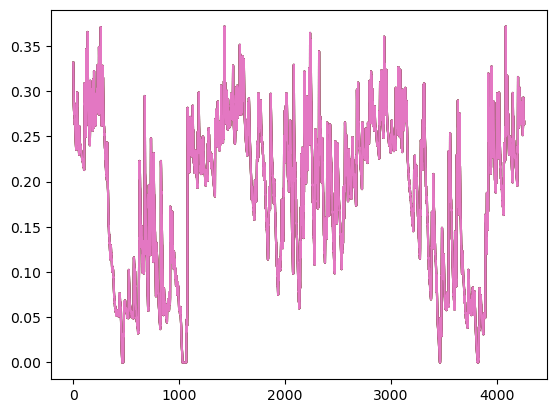

In [33]:
for i in range(7):
    plt.plot(result[:,i,i_swvl1])
plt.show()

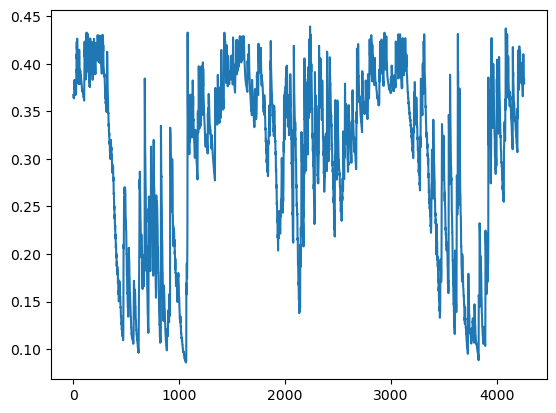

In [36]:
for i in range(8,9):
    plt.plot(result[:,i,i_swvl1])
plt.show()

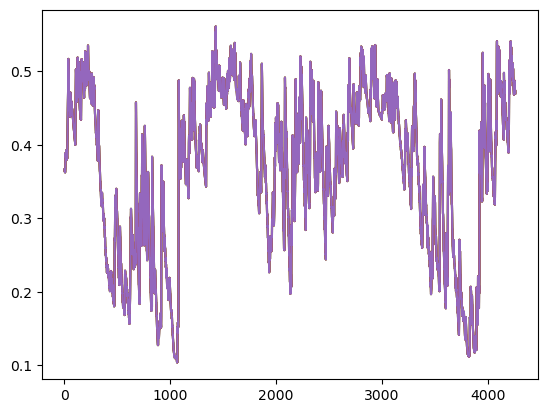

In [41]:
for i in range(9,14):
    plt.plot(result[:,i,i_swvl1])
plt.show()

In [5]:
var="aco2gpp"

In [6]:
def SMI(ds):
    static_fields = [field_cap.sel(x=ds["x"]), wilt_point.sel(x=ds["x"])]
    smi = 1. - 1. / ( 1. + (ds/np.mean(static_fields))**6 )
    return smi

In [7]:
ref_daily = ds_ref.sel(variable=["swvl1","swvl2","swvl3"]).data.resample(time="1d").mean(dim=("time","variable"))
mod_daily = ds_mod.sel(variable=["swvl1","swvl2","swvl3"]).data.resample(time="1d").mean(dim=("time","variable"))

In [12]:
smi_ref = SMI(ref_daily)
smi_mod = SMI(mod_daily)

In [21]:
ref_daily_gpp = ds_ref.sel(variable="aco2gpp").data.resample(time="1d").sum(dim="time")
mod_daily_gpp = ds_mod.sel(variable="aco2gpp").data.resample(time="1d").sum(dim="time")

In [14]:
from matplotlib.colors import LinearSegmentedColormap

In [22]:
x = smi_ref.values.reshape(-1)
y = ref_daily_gpp.values.reshape(-1)

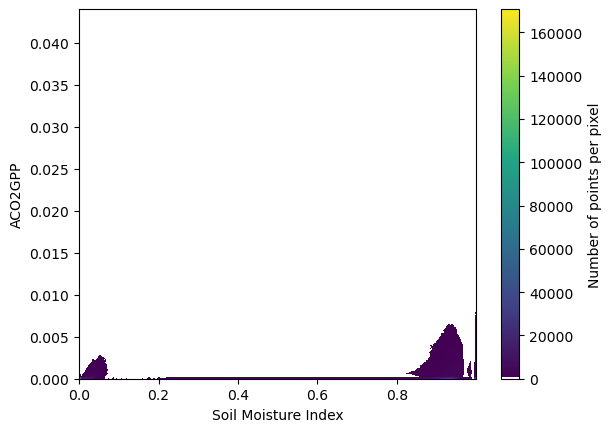

In [16]:
# "Viridis-like" colormap with white background
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, '#440053'),
    (0.2, '#404388'),
    (0.4, '#2a788e'),
    (0.6, '#21a784'),
    (0.8, '#78d151'),
    (1, '#fde624'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis)
    fig.colorbar(density, label='Number of points per pixel')
    ax.set(xlabel="Soil Moisture Index", ylabel="ACO2GPP")

fig = plt.figure()
using_mpl_scatter_density(fig, x, y)
plt.show()

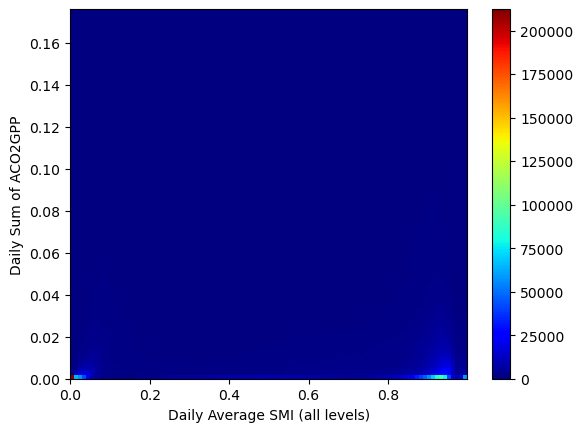

In [30]:
fig, ax = plt.subplots()
im = ax.hist2d(x, y, bins=(100, 100), cmap=plt.cm.jet)
fig.colorbar(im[3], ax=ax)
plt.xlabel("Daily Average SMI (all levels)")
plt.ylabel("Daily Sum of ACO2GPP")
plt.show()

In [ ]:
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
        (0, '#ffffff'),
        (100, '#440053'),
        (200, '#404388'),
        (400, '#2a788e'),
        (600, '#21a784'),
        (800, '#78d151'),
        (1000, '#fde624'),], N=256)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density(, )
density.set_clim(0, 2)


In [ ]:
plt.plot(smi)
plt.show()
plt.plot(ds_ref.sel(variable="aco2gpp").data.isel(x=i))
plt.show()